In [8]:
import json
import os
import re
from glob import glob

import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Load OpenHands output data

In [9]:
def load_df_from_oss(output_dir: str):
    if not os.path.exists(f'{output_dir}/output.swebench_eval.jsonl'):
        print(
            f'[{"/".join(output_dir.split("/")[-3:])}/output.swebench_eval.jsonl] does not exist'
        )
        return None
    df = pd.read_json(f'{output_dir}/output.swebench_eval.jsonl', lines=True)
    df['resolved'] = df['test_result'].apply(
        lambda x: x['report']['resolved'] if 'report' in x else False
    )
    resolved_df = df[df['resolved']][['instance_id']]
    print(
        f'Resolved {len(resolved_df)}/{len(df)} instances: {"/".join(output_dir.split("/")[-3:])}'
    )

    # Load trajectories for resolved instances
    def load_completions(instance_id: str):
        glob_path = os.path.join(output_dir, 'llm_completions', instance_id, '*.json')
        files = sorted(glob(glob_path))  # this is ascending order
        # pick the last file (last turn)
        try:
            file_path = files[-1]
        except IndexError:
            # print(f'No files found for instance {instance_id}: files={files}')
            return None
        with open(file_path, 'r') as f:
            result = json.load(f)
        # create messages
        messages = result['messages']
        messages.append(result['response']['choices'][0]['message'])
        # tools = result['kwargs']['tools']
        return messages

    def cleanup_messages(messages):
        """Convert the content of messages from list to string."""
        ret = []
        for message in messages:
            if 'content' in message and isinstance(message['content'], list):
                message['content'] = ' '.join((m['text'] for m in message['content']))
            ret.append(message)
        return ret

    df['messages'] = df['instance_id'].apply(load_completions)
    # skip the instances that have no completions
    _before = len(df)
    df = df[df['messages'].notna()]
    _after = len(df)
    if _before != _after:
        print(f'Skipped {_before - _after} instances that have no completions')
    df['messages'] = df['messages'].apply(cleanup_messages)
    df['n_messages'] = df['messages'].apply(len)
    df['output_dir'] = output_dir
    return df


output_dirs = glob(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5-ep5_maxiter_100_N_v2.2-no-hint-t0-run_*'
)
output_dirs += [
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5_maxiter_100_N_v2.2-no-hint-t0-run_1',
]
print(f'Found {len(output_dirs)} output dirs: {output_dirs}')

df = pd.concat([load_df_from_oss(output_dir) for output_dir in output_dirs])
print(f'Total resolved instances: {df["resolved"].sum()}/{len(df)}')

Found 17 output dirs: ['/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5-ep5_maxiter_100_N_v2.2-no-hint-t0-run_14', '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5-ep5_maxiter_100_N_v2.2-no-hint-t0-run_3', '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5-ep5_maxiter_100_N_v2.2-no-hint-t0-run_5', '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/princeton-nlp__SWE-bench_Verified-test/CodeActAgent/1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5-ep5_maxiter_100_N_v2.2-no-hint-t0-run_7', '/home/xingyaow/OpenHands-sw

In [16]:
df['directory'] = df['output_dir'].apply(lambda x: x.split('/')[-1])
df['run_id'] = df['output_dir'].apply(lambda x: re.search(r'run_(\d+)', x).group(1))
df['run_id'] = df['run_id'].astype(int)
df.loc[
    df['directory']
    == '1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full-lr1e-4-warmup5_maxiter_100_N_v2.2-no-hint-t0-run_1',
    'run_id',
] = 0

In [17]:
df_for_pass_at_n = df[['run_id', 'instance_id', 'resolved']].sort_values(
    by=['run_id', 'instance_id']
)
df_for_pass_at_n

,run_id,instance_id,resolved
79,0,astropy__astropy-12907,False
23,0,astropy__astropy-13033,False
32,0,astropy__astropy-13236,False
80,0,astropy__astropy-13398,False
69,0,astropy__astropy-13453,False
...,...,...,...
499,16,sympy__sympy-24213,False
495,16,sympy__sympy-24443,True
487,16,sympy__sympy-24539,True
492,16,sympy__sympy-24562,False


In [18]:
df_for_pass_at_n['run_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

# Data for RM Inference

In [21]:
def _convert_content(content) -> str:
    ret = ''
    if isinstance(content, list):
        for item in content:
            assert item['type'] == 'text', 'Only text is supported for now'
            ret += f'{item["text"]}\n'
    else:
        assert isinstance(content, str), 'Only str is supported for now'
        ret = content
    return ret


def convert_tool_call_to_string(tool_call: dict) -> str:
    """Convert tool call to content in string format."""
    if 'function' not in tool_call:
        raise ValueError("Tool call must contain 'function' key.")
    if 'id' not in tool_call:
        raise ValueError("Tool call must contain 'id' key.")
    if 'type' not in tool_call:
        raise ValueError("Tool call must contain 'type' key.")
    if tool_call['type'] != 'function':
        raise ValueError("Tool call type must be 'function'.")

    ret = f"<function={tool_call['function']['name']}>\n"
    try:
        args = json.loads(tool_call['function']['arguments'])
    except json.JSONDecodeError as e:
        raise ValueError(
            f"Failed to parse arguments as JSON. Arguments: {tool_call['function']['arguments']}"
        ) from e
    for param_name, param_value in args.items():
        is_multiline = isinstance(param_value, str) and '\n' in param_value
        ret += f'<parameter={param_name}>'
        if is_multiline:
            ret += '\n'
        ret += f'{param_value}'
        if is_multiline:
            ret += '\n'
        ret += '</parameter>\n'
    ret += '</function>'
    return ret


def format_traj(traj) -> str:
    output = ''
    system_message = None

    # Handle system message if present
    if traj[0]['role'] == 'system':
        system_message = traj[0]
        traj = traj[1:]
        content = _convert_content(system_message['content'])
        output += "*** System Message that describes the assistant's behavior ***\n"
        output += f'{content}\n'

    # Merge consecutive user messages first
    merged_traj = []
    current_messages = []

    for i, message in enumerate(traj):
        if message['role'] == 'user':
            current_messages.append(message)
        else:
            if current_messages:
                # Merge all accumulated user messages into one
                merged_content = '\n'.join(
                    _convert_content(msg['content']) for msg in current_messages
                )
                merged_traj.append({'role': 'user', 'content': merged_content})
                current_messages = []
            merged_traj.append(message)

    # Don't forget to handle any remaining user messages
    if current_messages:
        merged_content = '\n'.join(
            _convert_content(msg['content']) for msg in current_messages
        )
        merged_traj.append({'role': 'user', 'content': merged_content})

    # Now process the merged trajectory
    for i, message in enumerate(merged_traj):
        role, content = message['role'], message['content']
        content = _convert_content(content) if isinstance(content, list) else content
        turn_id = i // 2 + 1
        output += '-' * 100 + '\n'
        output += f'*** Turn {turn_id} - {role.upper() if role != "tool" else "TOOL EXECUTION RESULT"} ***\n'

        if role == 'user':
            output += f'{content}\n'
        elif role == 'tool':
            output += f'{content}\n'
        elif role == 'assistant':
            output += f'{content}\n'
            if (
                'tool_calls' in message
                and message['tool_calls'] is not None
                and len(message['tool_calls']) > 0
            ):
                for toolcall_id, tool_call in enumerate(message['tool_calls']):
                    output += f'### Tool Call {toolcall_id}\n'
                    output += f'{convert_tool_call_to_string(tool_call)}\n'
        else:
            raise ValueError(f'Unexpected role: {role}')

    output += '-' * 100 + '\n'
    return output


df['traj_str'] = df['messages'].progress_apply(lambda x: format_traj(x))

100%|██████████| 8496/8496 [00:01<00:00, 6590.51it/s]


In [ ]:
IN_CONTEXT_LEARNING_EXAMPLE_PREFIX = """
Here's a running example of how to perform a task with the provided tools.

--------------------- START OF EXAMPLE ---------------------

USER: Create a list of numbers from 1 to 10, and display them in a web page at port 5000.

ASSISTANT: Sure! Let me first check the current directory:
<function=execute_bash>
<parameter=command>
pwd && ls
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
/workspace
openhands@runtime:~/workspace$

ASSISTANT: There is no `app.py` file in the current directory. Let me create a Python file `app.py`:
<function=str_replace_editor>
<parameter=command>create</parameter>
<parameter=path>/workspace/app.py</parameter>
<parameter=file_text>
from flask import Flask
app = Flask(__name__)

@app.route('/')
def index():
    numbers = list(range(1, 11))
    return str(numbers)

if __name__ == '__main__':
    app.run(port=5000)
</parameter>
</function>

USER: EXECUTION RESULT of [str_replace_editor]:
File created successfully at: /workspace/app.py

ASSISTANT: I have created a Python file `app.py` that will display a list of numbers from 1 to 10 when you run it. Let me run the Python file for you:
<function=execute_bash>
<parameter=command>
python3 app.py > server.log 2>&1 &
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
[1] 121
[1]+  Exit 1                  python3 app.py > server.log 2>&1

ASSISTANT: Looks like the server is running with PID 121 then crashed. Let me check the server log:
<function=execute_bash>
<parameter=command>
cat server.log
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
Traceback (most recent call last):
  File "/workspace/app.py", line 2, in <module>
    from flask import Flask
ModuleNotFoundError: No module named 'flask'

ASSISTANT: Looks like the server crashed because the `flask` module is not installed. Let me install the `flask` module for you:
<function=execute_bash>
<parameter=command>
pip3 install flask
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
Defaulting to user installation because normal site-packages is not writeable
Collecting flask
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
Collecting blinker>=1.6.2
  Using cached blinker-1.7.0-py3-none-any.whl (13 kB)
Collecting Werkzeug>=3.0.0
  Using cached werkzeug-3.0.2-py3-none-any.whl (226 kB)
Collecting click>=8.1.3
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
Collecting itsdangerous>=2.1.2
  Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Requirement already satisfied: Jinja2>=3.1.2 in /home/openhands/.local/lib/python3.10/site-packages (from flask) (3.1.3)
Requirement already satisfied: MarkupSafe>=2.0 in /home/openhands/.local/lib/python3.10/site-packages (from Jinja2>=3.1.2->flask) (2.1.5)
Installing collected packages: Werkzeug, itsdangerous, click, blinker, flask
Successfully installed Werkzeug-3.0.2 blinker-1.7.0 click-8.1.7 flask-3.0.3 itsdangerous-2.2.0

ASSISTANT: The `flask` module is installed successfully. Let me run the Python file again:
<function=execute_bash>
<parameter=command>
python3 app.py > server.log 2>&1 &
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
[1] 124

ASSISTANT:
Let me check the server log again:
<function=execute_bash>
<parameter=command>
cat server.log
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
* Serving Flask app 'app'
 * Debug mode: off
WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit

ASSISTANT:
The server is running on port 5000 with PID 124. You can access the list of numbers by visiting http://127.0.0.1:5000. If you have any further questions, feel free to ask!

USER: Now kill the server, make it display the numbers in a table format.

ASSISTANT:
Sure! Let me stop the server first:
<function=execute_bash>
<parameter=command>
kill 124
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
[1]+  Terminated              python3 app.py > server.log 2>&1

ASSISTANT:
Now let me display the numbers in a table format:
<function=str_replace_editor>
<parameter=command>str_replace</parameter>
<parameter=path>/workspace/app.py</parameter>
<parameter=old_str>return str(numbers)</parameter>
<parameter=new_str>return '<table>' + ''.join([f'<tr><td>{i}</td></tr>' for i in numbers]) + '</table>'</parameter>
</function>

USER: EXECUTION RESULT of [str_replace_editor]:
The file /workspace/app.py has been edited. Here's the result of running `cat -n` on a snippet of /workspace/app.py:
     3
     4  @app.route('/')
     5  def index():
     6      numbers = list(range(1, 11))
     7      return '<table>' + ''.join([f'<tr><td>{i}</td></tr>' for i in numbers]) + '</table>'
     8
     9  if __name__ == '__main__':
    10      app.run(port=5000)
Review the changes and make sure they are as expected. Edit the file again if necessary.

ASSISTANT:
Running the updated file:
<function=execute_bash>
<parameter=command>
<parameter=command>
python3 app.py > server.log 2>&1 &
</parameter>
</function>

USER: EXECUTION RESULT of [execute_bash]:
[1] 126

ASSISTANT:
The server is running on port 5000 with PID 126. You can access the list of numbers in a table format by visiting http://127.0.0.1:5000. Let me know if you have any further requests!
<function=finish>
</function>

--------------------- END OF EXAMPLE ---------------------

Do NOT assume the environment is the same as in the example above.

--------------------- NEW TASK DESCRIPTION ---------------------
""".lstrip()

IN_CONTEXT_LEARNING_EXAMPLE_SUFFIX = """
--------------------- END OF NEW TASK DESCRIPTION ---------------------

PLEASE follow the format strictly! PLEASE EMIT ONE AND ONLY ONE FUNCTION CALL PER MESSAGE.
""".lstrip()

def replace_in_context_learning_example(traj_str):
    return traj_str.replace(IN_CONTEXT_LEARNING_EXAMPLE_PREFIX, '').replace(
        IN_CONTEXT_LEARNING_EXAMPLE_SUFFIX, ''
    )


df['traj_str'] = df['traj_str'].apply(replace_in_context_learning_example)

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-Coder-7B-Instruct')


def convert_traj_to_rm_prompt_for_inference(traj_str: str) -> str:
    SYSTEM_MESSAGE = """You are an expert judge evaluating AI assistant interactions. Your task is to determine if the assistant successfully resolved the user's request.

Key evaluation criteria:
1. Did the assistant complete the main task requested by the user?
2. Did the assistant handle all edge cases and requirements specified?
3. Were there any errors or issues in the final solution?
4. Did the assistant verify the solution works as intended?

Respond only with "<judgement>YES</judgement>" or "<judgement>NO</judgement>"."""
    USER_MESSAGE = (
        """Please evaluate the following interaction between an AI assistant and a user:

=== INTERACTION LOG ===
"""
        + traj_str
        + """
=== END INTERACTION ===

Based on the above interaction, did the assistant successfully resolve the user's initial request? Respond with YES or NO."""
    )
    tokenized_conv = tokenizer.apply_chat_template(
        [
            {'role': 'system', 'content': SYSTEM_MESSAGE},
            {'role': 'user', 'content': USER_MESSAGE},
            {'role': 'assistant', 'content': '<judgement>'},
        ],
        tokenize=False,
    )
    return tokenized_conv[: tokenized_conv.rfind('<judgement>') + len('<judgement>')]


# print(convert_traj_to_rm_prompt_for_inference(df.iloc[0]['traj_str'])[-100:])
df['rm_prompt'] = df.progress_apply(
    lambda row: convert_traj_to_rm_prompt_for_inference(row['traj_str']), axis=1
)

100%|██████████| 8496/8496 [00:00<00:00, 10868.70it/s]


In [ ]:
# for token statistics
# df['n_tokens'] = df['rm_prompt'].progress_apply(lambda x: len(tokenizer.apply_chat_template(x)))

In [23]:
df[['directory', 'run_id', 'instance_id', 'resolved', 'rm_prompt']].sort_values(
    by=['run_id', 'directory', 'instance_id']
).to_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-16+1runs-rm_prompt.jsonl',
    lines=True,
    orient='records',
)

# Load inferred results

Use `scripts/serving/infer_rm_sglang.py` to run inference.

In [24]:
import pandas as pd

rm_df = pd.read_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-16+1runs-rm_prompt.RM-claude+4o+onpolicy-1x-1116-sonnet-4o-491i-32k-qwen25_coder_32b_base_full-lr1e-4-lora-r64-a64__merged.output.jsonl',
    lines=True,
)


In [25]:
import numpy as np

def get_predict_resolve_score(rm_score: dict):
    input_token_logprobs = rm_score['input_token_logprobs']
    token_to_logprob = {
        # tup = [[logprob, token_id, token]]
        tup[0][2]: tup[0][0]
        for tup in input_token_logprobs
    }
    assert (
        ' YES' in token_to_logprob and ' NO' in token_to_logprob
    ), 'YES or NO not found in input_token_logprobs'
    yes_logprob = token_to_logprob[' YES']
    no_logprob = token_to_logprob[' NO']

    # softmax
    return np.exp(yes_logprob) / (np.exp(yes_logprob) + np.exp(no_logprob))


rm_df['rm_resolve_score'] = rm_df['rm_score'].apply(get_predict_resolve_score)
# rm_df['rm_resolve_score'].describe()

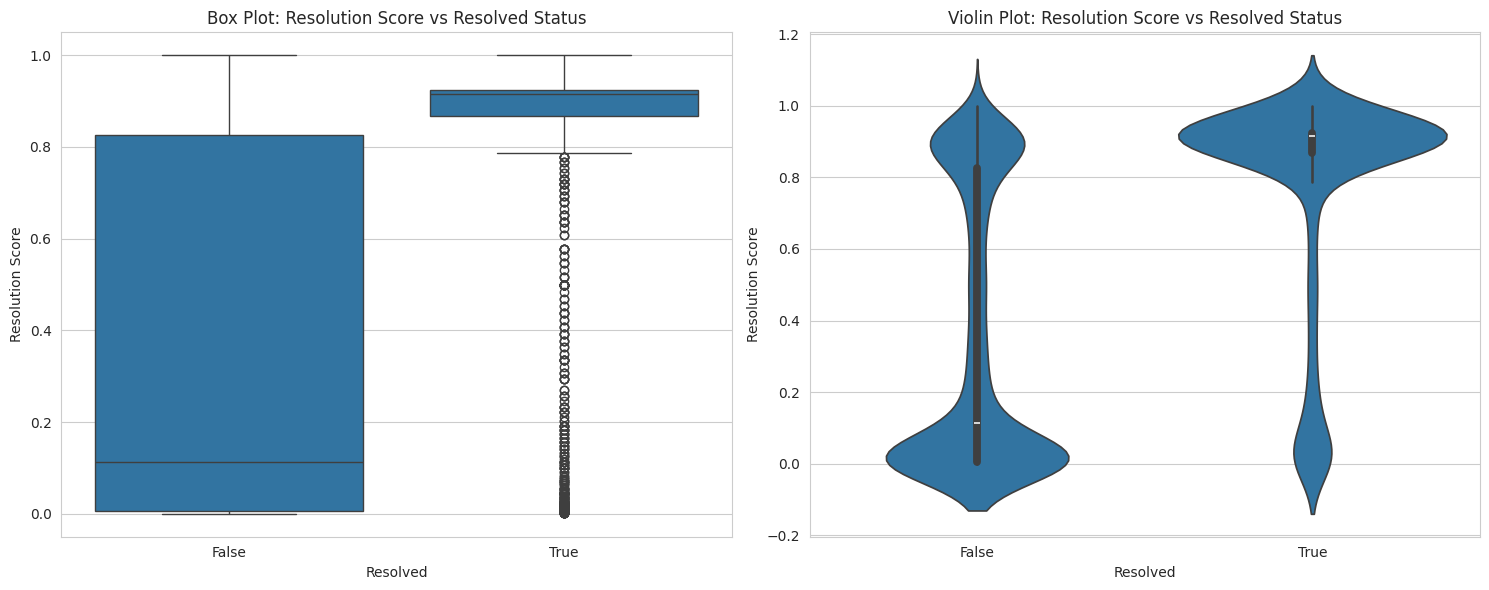


Statistical Summary:
           count      mean       std           min       25%       50%  \
resolved                                                                 
False     6957.0  0.348226  0.383514  1.914273e-07  0.005220  0.112795   
True      1539.0  0.765902  0.306241  1.098732e-03  0.867036  0.914901   

               75%       max  
resolved                      
False     0.826712  0.999996  
True      0.924142  0.999998  

Point-biserial correlation: 0.398
P-value: 0.000


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
sns.boxplot(data=rm_df, x='resolved', y='rm_resolve_score', ax=ax1)
ax1.set_title('Box Plot: Resolution Score vs Resolved Status')
ax1.set_xlabel('Resolved')
ax1.set_ylabel('Resolution Score')

# Violin plot
sns.violinplot(data=rm_df, x='resolved', y='rm_resolve_score', ax=ax2)
ax2.set_title('Violin Plot: Resolution Score vs Resolved Status')
ax2.set_xlabel('Resolved')
ax2.set_ylabel('Resolution Score')

plt.tight_layout()
plt.show()

# Print some statistical summary
print('\nStatistical Summary:')
print(rm_df.groupby('resolved')['rm_resolve_score'].describe())

# Optional: Calculate and print the point-biserial correlation
from scipy import stats

correlation, p_value = stats.pointbiserialr(
    rm_df['resolved'], rm_df['rm_resolve_score']
)
print(f'\nPoint-biserial correlation: {correlation:.3f}')
print(f'P-value: {p_value:.3f}')

In [27]:
import random

import matplotlib.pyplot as plt
import pandas as pd


def get_bootstrap_accuracy_std(
    values: float | int | bool, num_samples: int = 1000
) -> float:
    # Borrow from https://github.com/openai/evals/blob/cdb8ce9547e68b8e5e4520b6a162294c06865c0f/evals/metrics.py#L21
    return np.std(
        [np.mean(random.sample(values, len(values) // 2)) for _ in range(num_samples)]
    )


def calculate_pass_at_k(df, k_values):
    pass_at_k_rates = []
    best_at_k_rates = []
    for k in k_values:
        # Filter to only include attempts with run_id < k
        df_at_k = df[df['run_id'].astype(int) < k]

        # Group by instance_id and select the attempt with highest rm_resolve_score
        def select_best_attempt(group):
            best_attempt = group.loc[group['rm_resolve_score'].idxmax()]
            return best_attempt['resolved']

        # Group by instance_id and check if any attempt succeeded
        group_by_instance_id = df_at_k.groupby('instance_id')

        is_any_attempt_resolved = group_by_instance_id['resolved'].any()
        is_best_attempt_resolved = group_by_instance_id.apply(select_best_attempt)
        print(
            f'instance_results for k={k}, len instance_results={len(is_any_attempt_resolved)}'
        )

        # Calculate pass rate
        best_at_k_rate = is_best_attempt_resolved.mean() * 100
        best_at_k_rate_std = (
            get_bootstrap_accuracy_std(is_best_attempt_resolved.tolist()) * 100
        )

        pass_at_k_rate = is_any_attempt_resolved.mean() * 100
        pass_at_k_rate_std = (
            get_bootstrap_accuracy_std(is_any_attempt_resolved.tolist()) * 100
        )

        pass_at_k_rates.append((pass_at_k_rate, pass_at_k_rate_std))
        best_at_k_rates.append((best_at_k_rate, best_at_k_rate_std))

    return pass_at_k_rates, best_at_k_rates

In [225]:
def calculate_pass_at_k_smooth(rm_df_for_pass_at_n, N=16, fixed_first_run=False):
    # %%
    from random import shuffle

    import numpy as np

    def calculate_average_scores(id_rankings_dict, N, num_trials=100):
        total_instances = len(id_rankings_dict)  # Get actual number of instances
        pass_at_n_trials = np.zeros((num_trials, N))
        best_of_n_trials = np.zeros((num_trials, N))

        # Run multiple trials
        for trial in range(num_trials):
            pass_at_n = np.zeros(N)
            best_of_n = np.zeros(N)

            # Process each instance
            for instance_id, rankings in id_rankings_dict.items():
                rankings = list(rankings.values())
                if not fixed_first_run:
                    shuffle(rankings)

                # Process each N value
                for idx in range(N):
                    # Shuffle for the second run (so we keep the first run perf unchanged)
                    if fixed_first_run and idx == 1:
                        shuffle(rankings)  # Shuffle for this trial

                    n_rankings = rankings[: idx + 1]
                    n_rankings.sort(key=lambda x: x[1], reverse=True)  # Sort by score

                    # Best of N - only look at the top scoring one
                    if n_rankings[0][0] == True:
                        best_of_n[idx] += 1

                    # Pass at N - check if any are True
                    if True in [x[0] for x in n_rankings]:
                        pass_at_n[idx] += 1

            # Store results for this trial
            pass_at_n_trials[trial] = pass_at_n
            best_of_n_trials[trial] = best_of_n

        # Calculate means and standard deviations
        pass_at_n_mean = np.mean(pass_at_n_trials, axis=0)
        pass_at_n_std = np.std(pass_at_n_trials, axis=0)
        best_of_n_mean = np.mean(best_of_n_trials, axis=0)
        best_of_n_std = np.std(best_of_n_trials, axis=0)

        # Convert to percentages
        pass_at_n_mean_pct = [x / total_instances * 100 for x in pass_at_n_mean]
        pass_at_n_std_pct = [x / total_instances * 100 for x in pass_at_n_std]
        best_of_n_mean_pct = [x / total_instances * 100 for x in best_of_n_mean]
        best_of_n_std_pct = [x / total_instances * 100 for x in best_of_n_std]

        return {
            'pass_at_n_mean': pass_at_n_mean_pct,
            'pass_at_n_std': pass_at_n_std_pct,
            'best_of_n_mean': best_of_n_mean_pct,
            'best_of_n_std': best_of_n_std_pct,
        }

    # Calculate pass@k and best@k rates with bootstrapping
    num_trials = 100  # Number of bootstrap trials

    # Create id_rankings_dict from rm_df_for_pass_at_n
    id_rankings_dict = {}
    for _, row in rm_df_for_pass_at_n.iterrows():
        instance_id = row['instance_id']
        if instance_id not in id_rankings_dict:
            id_rankings_dict[instance_id] = {}

        run_id = row['run_id']
        id_rankings_dict[instance_id][run_id] = (
            row['resolved'],
            row['rm_resolve_score'],
        )

    results = calculate_average_scores(id_rankings_dict, N, num_trials)

    # Format results for plotting
    pass_at_k_rates = list(zip(results['pass_at_n_mean'], results['pass_at_n_std']))
    best_at_k_rates = list(zip(results['best_of_n_mean'], results['best_of_n_std']))
    return pass_at_k_rates, best_at_k_rates

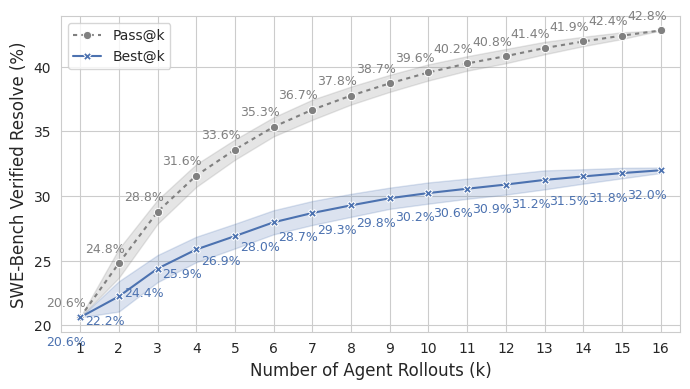

In [229]:
BEST_AT_K_COLOR = 'blue'
PASS_AT_K_COLOR = 'gray'

# Define k values to evaluate
k_values = list(range(1, 17))

# Calculate pass@k
rm_df_for_pass_at_n = rm_df[
    ['run_id', 'instance_id', 'resolved', 'rm_resolve_score']
].sort_values(by=['run_id', 'instance_id'])

pass_at_k_rates, best_at_k_rates = calculate_pass_at_k_smooth(
    rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] < 16], N=16, fixed_first_run=True
)


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create a DataFrame in long format for seaborn
plot_data = []
for k, (pass_rate, best_rate) in enumerate(zip(pass_at_k_rates, best_at_k_rates), 1):
    plot_data.append(
        {
            'k': k,
            'Rate': pass_rate[0],
            'Error': pass_rate[1],
            'Metric': 'Pass@k',
            'Lower': pass_rate[0] - pass_rate[1],
            'Upper': pass_rate[0] + pass_rate[1],
        }
    )
    plot_data.append(
        {
            'k': k,
            'Rate': best_rate[0],
            'Error': best_rate[1],
            'Metric': 'Best@k',
            'Lower': best_rate[0] - best_rate[1],
            'Upper': best_rate[0] + best_rate[1],
        }
    )
df_plot = pd.DataFrame(plot_data)
# Set the style
sns.set_style('whitegrid')
# Define colors
GRAY_COLOR = '#808080'
BLUE_COLOR = sns.color_palette('deep')[0]  # Seaborn's default blue
colors = {'Pass@k': GRAY_COLOR, 'Best@k': BLUE_COLOR}
plt.figure(figsize=(7, 4))
# Create the plot
sns.lineplot(
    data=df_plot,
    x='k',
    y='Rate',
    hue='Metric',
    style='Metric',
    markers=True,
    dashes=[(2, 2), ()],  # Use line style tuples instead of boolean values
    palette=colors,
)
# Add error bands
for metric, color in colors.items():
    metric_data = df_plot[df_plot['Metric'] == metric]
    plt.fill_between(
        metric_data['k'],
        metric_data['Lower'],
        metric_data['Upper'],
        alpha=0.2,
        color=color,
    )
# Add value labels
for metric, color in colors.items():
    metric_data = df_plot[df_plot['Metric'] == metric]
    for _, row in metric_data.iterrows():
        plt.annotate(
            f'{row["Rate"]:.1f}%',
            (row['k'], row['Rate']),
            textcoords='offset points',
            xytext=(-10, 8 if metric == 'Pass@k' else -20),
            ha='center',
            color=color,
            fontsize=9,
        )
# Customize plot
plt.xlabel('Number of Agent Rollouts (k)', fontsize=12)
plt.ylabel('SWE-Bench Verified Resolve (%)', fontsize=12)
# plt.title('Inference Time Scaling with Trained Verifier\n(Agent: fine-tuned Qwen2.5-Coder-Instruct-32B w/ OpenHands)', fontsize=13)
plt.xlim(0.5, max(k_values) + 0.5)
plt.xticks(k_values)
# plt.xscale('log', base=2)
# Improve legend
plt.legend(title=None, loc='upper left')
plt.tight_layout()
plt.savefig('plots/openhands-32b-pass-at-n.pdf', bbox_inches='tight')

/tmp/ipykernel_281579/2387164136.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(np.exp(x1_line), y1_line, 'r--', alpha=0.5, color='gray',


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

/tmp/ipykernel_281579/2387164136.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(np.exp(x2_line), y2_line, 'r--', alpha=0.8, color='gray',


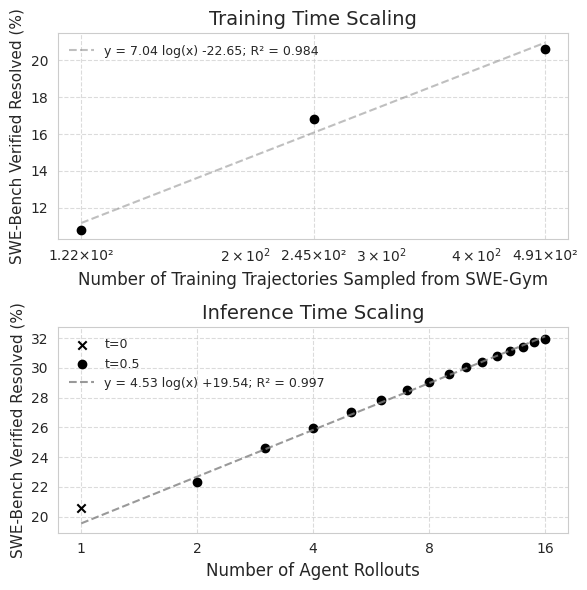

In [220]:
# Create figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Top plot - Training time scaling with log scale
_train_data_scaling_df = pd.DataFrame(
    [
        {'percentage': 1.0, 'resolve_rate': 20.6, 'model': '32B'},
        {'percentage': 0.5, 'resolve_rate': 16.8, 'model': '32B'},
        {'percentage': 0.25, 'resolve_rate': 10.8, 'model': '32B'},
    ]
)
_train_data_scaling_df['num_data'] = (
    _train_data_scaling_df['percentage'] * 491
).astype(int)

# Add linear regression for top plot
from scipy import stats

x1 = np.log(_train_data_scaling_df['num_data'])
y1 = _train_data_scaling_df['resolve_rate']
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
x1_line = np.linspace(np.min(x1), np.max(x1), 100)
y1_line = slope1 * x1_line + intercept1

# Plot original points and regression line
ax1.scatter(
    _train_data_scaling_df['num_data'],
    _train_data_scaling_df['resolve_rate'],
    color='black',
)
# ax1.plot(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], '--', color='gray', alpha=0.5)
ax1.plot(
    np.exp(x1_line),
    y1_line,
    'r--',
    alpha=0.5,
    color='gray',
    label=f'y = {slope1:.2f} log(x) {intercept1:+.2f}; R² = {r_value1**2:.3f}',
)
ax1.set_xscale('log')

# ax1.scatter(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], color='black')
# ax1.plot(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], '--', color='gray', alpha=0.5)
# ax1.set_xscale('log')

# Set custom ticks and labels for top plot
custom_ticks = [122, 245, 491]  # Your actual data points
custom_labels = ['1.22×10²', '2.45×10²', '4.91×10²']  # Custom formatted labels
ax1.set_xticks(custom_ticks)
ax1.set_xticklabels(custom_labels)

# Customize top plot
ax1.set_xlabel('Number of Training Trajectories Sampled from SWE-Gym', fontsize=12)
ax1.set_ylabel('SWE-Bench Verified Resolved (%)', fontsize=11)
ax1.set_title('Training Time Scaling', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Calculate pass@k
rm_df_for_pass_at_n = rm_df[
    ['run_id', 'instance_id', 'resolved', 'rm_resolve_score']
].sort_values(by=['run_id', 'instance_id'])
# rm_df_for_pass_at_n = rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] != 0]
# rm_df_for_pass_at_n['run_id'] -= 1
# rm_df_for_pass_at_n = rm_df[rm_df['run_id'] > 0][['run_id', 'instance_id', 'resolved', 'rm_resolve_score']].sort_values(by=['run_id', 'instance_id'])
# pass_at_k_rates, best_at_k_rates = calculate_pass_at_k(rm_df_for_pass_at_n, k_values)
# _cur_rm_df_for_pass_at_n = rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] > 0].copy()
# _cur_rm_df_for_pass_at_n['run_id'] -= 1
_cur_rm_df_for_pass_at_n = rm_df_for_pass_at_n[
    rm_df_for_pass_at_n['run_id'] < 16
].copy()
display(_cur_rm_df_for_pass_at_n['run_id'].unique())
pass_at_k_rates, best_at_k_rates = calculate_pass_at_k_smooth(
    _cur_rm_df_for_pass_at_n, N=16, fixed_first_run=True
)


# # Bottom plot - Inference time scaling with log regression
# k_values = list(range(1, 17))
# best_rates = [rate[0] for rate in best_at_k_rates]

# # Add linear regression for bottom plot
# x2 = np.log(k_values)
# y2 = best_rates
# slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
# x2_line = np.linspace(np.min(x2), np.max(x2), 100)
# y2_line = slope2 * x2_line + intercept2

# # Plot original points and regression line
# ax2.scatter(k_values, best_rates, color='black')
# # ax2.plot(k_values, best_rates, '--', color='gray', alpha=0.5)
# ax2.plot(np.exp(x2_line), y2_line, 'r--', alpha=0.8, color='gray',
#          label=f'y = {slope2:.2f} log(x) {intercept2:+.2f}; R² = {r_value2**2:.3f}')
# ax2.set_xscale('log')

# Bottom plot - Inference time scaling with log regression
k_values = list(range(1, 17))
best_rates = [rate[0] for rate in best_at_k_rates]

# Add linear regression for bottom plot - excluding first point
x2 = np.log(k_values[1:])  # Start from second point
y2 = best_rates[1:]  # Start from second point
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
x2_line = np.linspace(np.min(np.log(k_values)), np.max(np.log(k_values)), 100)
y2_line = slope2 * x2_line + intercept2

# Plot points - first point with different marker
# ax2.scatter(k_values[0], best_rates[0], color='black', marker='x', zorder=2)  # First point as star
# ax2.scatter(k_values[1:], best_rates[1:], color='black', zorder=2)  # Rest of points as circles
# Plot points with different markers and add to legend
ax2.scatter(
    k_values[0], best_rates[0], color='black', marker='x', zorder=3, label='t=0'
)  # First point as x
ax2.scatter(k_values[1:], best_rates[1:], color='black', zorder=2, label='t=0.5')

# Plot regression line
ax2.plot(
    np.exp(x2_line),
    y2_line,
    'r--',
    alpha=0.8,
    color='gray',
    label=f'y = {slope2:.2f} log(x) {intercept2:+.2f}; R² = {r_value2**2:.3f}',
)
ax2.set_xscale('log')

# Set custom ticks for bottom plot - using powers of 2
custom_ticks = [1, 2, 4, 8, 16]
ax2.set_xticks(custom_ticks)
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Customize bottom plot
ax2.set_xlabel('Number of Agent Rollouts', fontsize=12)
ax2.set_ylabel('SWE-Bench Verified Resolved (%)', fontsize=11)
ax2.set_title('Inference Time Scaling', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add legends
ax1.legend(fontsize=9, frameon=False)
ax2.legend(fontsize=9, frameon=False)

plt.tight_layout()
plt.savefig('plots/openhands-fig1-scaling.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_281579/3763980101.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(np.exp(x1_line), y1_line, 'r--', alpha=0.5, color='gray',


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

/tmp/ipykernel_281579/3763980101.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(np.exp(x2_line), y2_line, 'r--', alpha=0.8, color='gray',


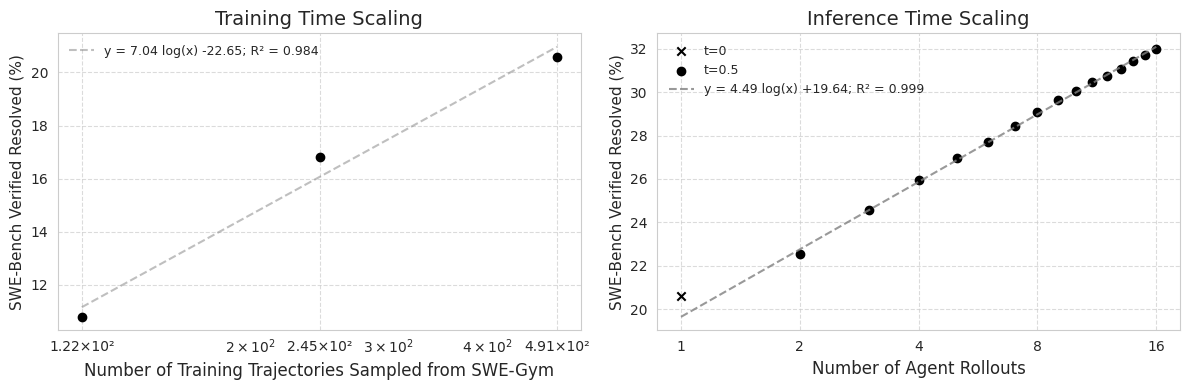

In [234]:
# Create figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Top plot - Training time scaling with log scale
_train_data_scaling_df = pd.DataFrame(
    [
        {'percentage': 1.0, 'resolve_rate': 20.6, 'model': '32B'},
        {'percentage': 0.5, 'resolve_rate': 16.8, 'model': '32B'},
        {'percentage': 0.25, 'resolve_rate': 10.8, 'model': '32B'},
    ]
)
_train_data_scaling_df['num_data'] = (
    _train_data_scaling_df['percentage'] * 491
).astype(int)

# Add linear regression for top plot
from scipy import stats

x1 = np.log(_train_data_scaling_df['num_data'])
y1 = _train_data_scaling_df['resolve_rate']
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
x1_line = np.linspace(np.min(x1), np.max(x1), 100)
y1_line = slope1 * x1_line + intercept1

# Plot original points and regression line
ax1.scatter(
    _train_data_scaling_df['num_data'],
    _train_data_scaling_df['resolve_rate'],
    color='black',
)
# ax1.plot(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], '--', color='gray', alpha=0.5)
ax1.plot(
    np.exp(x1_line),
    y1_line,
    'r--',
    alpha=0.5,
    color='gray',
    label=f'y = {slope1:.2f} log(x) {intercept1:+.2f}; R² = {r_value1**2:.3f}',
)
ax1.set_xscale('log')

# ax1.scatter(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], color='black')
# ax1.plot(_train_data_scaling_df['num_data'], _train_data_scaling_df['resolve_rate'], '--', color='gray', alpha=0.5)
# ax1.set_xscale('log')

# Set custom ticks and labels for top plot
custom_ticks = [122, 245, 491]  # Your actual data points
custom_labels = ['1.22×10²', '2.45×10²', '4.91×10²']  # Custom formatted labels
ax1.set_xticks(custom_ticks)
ax1.set_xticklabels(custom_labels)

# Customize top plot
ax1.set_xlabel('Number of Training Trajectories Sampled from SWE-Gym', fontsize=12)
ax1.set_ylabel('SWE-Bench Verified Resolved (%)', fontsize=11)
ax1.set_title('Training Time Scaling', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Calculate pass@k
rm_df_for_pass_at_n = rm_df[
    ['run_id', 'instance_id', 'resolved', 'rm_resolve_score']
].sort_values(by=['run_id', 'instance_id'])
# rm_df_for_pass_at_n = rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] != 0]
# rm_df_for_pass_at_n['run_id'] -= 1
# rm_df_for_pass_at_n = rm_df[rm_df['run_id'] > 0][['run_id', 'instance_id', 'resolved', 'rm_resolve_score']].sort_values(by=['run_id', 'instance_id'])
# pass_at_k_rates, best_at_k_rates = calculate_pass_at_k(rm_df_for_pass_at_n, k_values)
# _cur_rm_df_for_pass_at_n = rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] > 0].copy()
# _cur_rm_df_for_pass_at_n['run_id'] -= 1
_cur_rm_df_for_pass_at_n = rm_df_for_pass_at_n[
    rm_df_for_pass_at_n['run_id'] < 16
].copy()
display(_cur_rm_df_for_pass_at_n['run_id'].unique())
pass_at_k_rates, best_at_k_rates = calculate_pass_at_k_smooth(
    _cur_rm_df_for_pass_at_n, N=16, fixed_first_run=True
)


# # Bottom plot - Inference time scaling with log regression
# k_values = list(range(1, 17))
# best_rates = [rate[0] for rate in best_at_k_rates]

# # Add linear regression for bottom plot
# x2 = np.log(k_values)
# y2 = best_rates
# slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
# x2_line = np.linspace(np.min(x2), np.max(x2), 100)
# y2_line = slope2 * x2_line + intercept2

# # Plot original points and regression line
# ax2.scatter(k_values, best_rates, color='black')
# # ax2.plot(k_values, best_rates, '--', color='gray', alpha=0.5)
# ax2.plot(np.exp(x2_line), y2_line, 'r--', alpha=0.8, color='gray',
#          label=f'y = {slope2:.2f} log(x) {intercept2:+.2f}; R² = {r_value2**2:.3f}')
# ax2.set_xscale('log')

# Bottom plot - Inference time scaling with log regression
k_values = list(range(1, 17))
best_rates = [rate[0] for rate in best_at_k_rates]

# Add linear regression for bottom plot - excluding first point
x2 = np.log(k_values[1:])  # Start from second point
y2 = best_rates[1:]  # Start from second point
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
x2_line = np.linspace(np.min(np.log(k_values)), np.max(np.log(k_values)), 100)
y2_line = slope2 * x2_line + intercept2

# Plot points - first point with different marker
# ax2.scatter(k_values[0], best_rates[0], color='black', marker='x', zorder=2)  # First point as star
# ax2.scatter(k_values[1:], best_rates[1:], color='black', zorder=2)  # Rest of points as circles
# Plot points with different markers and add to legend
ax2.scatter(
    k_values[0], best_rates[0], color='black', marker='x', zorder=3, label='t=0'
)  # First point as x
ax2.scatter(k_values[1:], best_rates[1:], color='black', zorder=2, label='t=0.5')

# Plot regression line
ax2.plot(
    np.exp(x2_line),
    y2_line,
    'r--',
    alpha=0.8,
    color='gray',
    label=f'y = {slope2:.2f} log(x) {intercept2:+.2f}; R² = {r_value2**2:.3f}',
)
ax2.set_xscale('log')

# Set custom ticks for bottom plot - using powers of 2
custom_ticks = [1, 2, 4, 8, 16]
ax2.set_xticks(custom_ticks)
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Customize bottom plot
ax2.set_xlabel('Number of Agent Rollouts', fontsize=12)
ax2.set_ylabel('SWE-Bench Verified Resolved (%)', fontsize=11)
ax2.set_title('Inference Time Scaling', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add legends
ax1.legend(fontsize=9, frameon=False)
ax2.legend(fontsize=9, frameon=False)

plt.tight_layout()
plt.savefig('plots/openhands-fig1-scaling-horizontal.pdf', bbox_inches='tight')
plt.show()

# Ablation Study

In [153]:
rm_df_offpolicy = pd.read_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-8+1runs-rm_prompt.output.jsonl',
    lines=True,
)
rm_df_offpolicy_2x = pd.read_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-8+1runs-rm_prompt.RM-2x-1116-sonnet-4o-491i-32k-qwen25_coder_32b_base_full-lr1e-4__epoch_4.output.jsonl',
    lines=True,
)
rm_df_mix = pd.read_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-8+1runs-rm_prompt.RM-claude+4o+onpolicy-1x-1116-sonnet-4o-491i-32k-qwen25_coder_32b_base_full-lr1e-4__epoch_4.output.jsonl',
    lines=True,
)
rm_df_onpolicy = pd.read_json(
    '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/rm_exp/qwencoder-32b-1116-sonnet-4o-491i-32k-8+1runs-rm_prompt.RM-onpolicy-1x-1116-sonnet-4o-491i-32k-qwen25_coder_32b_base_full-lr1e-4-try1__epoch_4.output.jsonl',
    lines=True,
)  # Calculate pass@k

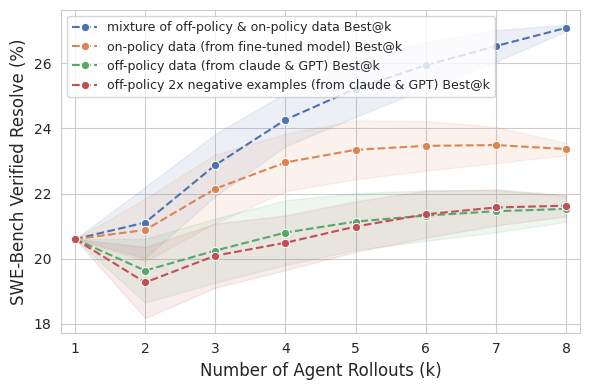

In [228]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8]
# , 9]


def get_pass_at_k_rates(rm_df):
    rm_df['rm_resolve_score'] = rm_df['rm_score'].apply(get_predict_resolve_score)
    rm_df_for_pass_at_n = rm_df[
        ['run_id', 'instance_id', 'resolved', 'rm_resolve_score']
    ].sort_values(by=['run_id', 'instance_id'])

    pass_at_k_rates, best_at_k_rates = calculate_pass_at_k_smooth(
        rm_df_for_pass_at_n[rm_df_for_pass_at_n['run_id'] < 8],
        N=8,
        fixed_first_run=True,
    )
    return pass_at_k_rates, best_at_k_rates


# Get pass@k rates for each run
offpolicy_rates = get_pass_at_k_rates(rm_df_offpolicy)
offpolicy_2x_rates = get_pass_at_k_rates(rm_df_offpolicy_2x)
mix_rates = get_pass_at_k_rates(rm_df_mix)
onpolicy_rates = get_pass_at_k_rates(rm_df_onpolicy)

# Create plot data combining all runs
plot_data = []
run_names = {
    'mixture of off-policy & on-policy data': mix_rates,
    'on-policy data (from fine-tuned model)': onpolicy_rates,
    'off-policy data (from claude & GPT)': offpolicy_rates,
    'off-policy 2x negative examples (from claude & GPT)': offpolicy_2x_rates,
}

for run_name, (pass_at_k_rates, best_at_k_rates) in run_names.items():
    for k, (pass_rate, best_rate) in enumerate(
        zip(pass_at_k_rates, best_at_k_rates), 1
    ):
        plot_data.append(
            {
                'k': k,
                'Rate': pass_rate[0],
                'Error': pass_rate[1],
                'Metric': 'Pass@k',
                'Run': run_name,
                'Lower': pass_rate[0] - pass_rate[1],
                'Upper': pass_rate[0] + pass_rate[1],
            }
        )
        plot_data.append(
            {
                'k': k,
                'Rate': best_rate[0],
                'Error': best_rate[1],
                'Metric': 'Best@k',
                'Run': run_name,
                'Lower': best_rate[0] - best_rate[1],
                'Upper': best_rate[0] + best_rate[1],
            }
        )

df_plot = pd.DataFrame(plot_data)

# Set the style
sns.set_style('whitegrid')

# Define colors - one for each run
colors = sns.color_palette('deep', n_colors=len(run_names))
run_colors = dict(zip(run_names.keys(), colors))

plt.figure(figsize=(6, 4))

# Create separate plots for Pass@k and Best@k
for metric in ['Pass@k', 'Best@k']:
    metric_data = df_plot[df_plot['Metric'] == metric]

    # Plot lines for each run
    for i, run_name in enumerate(run_names.keys()):
        # disable pass@k
        if metric == 'Pass@k':
            break

        run_data = metric_data[metric_data['Run'] == run_name]
        if i > 0 and metric == 'Pass@k':
            break

        # Main line
        sns.lineplot(
            data=run_data,
            x='k',
            y='Rate',
            label=f'{run_name} {metric}' if metric != 'Pass@k' else metric,
            marker='o',
            color=run_colors[run_name] if metric != 'Pass@k' else 'gray',
            linestyle='-' if metric == 'Pass@k' else '--',
        )

        # Error bands
        plt.fill_between(
            run_data['k'],
            run_data['Lower'],
            run_data['Upper'],
            alpha=0.1,
            color=run_colors[run_name],
        )

# Customize plot
plt.xlabel('Number of Agent Rollouts (k)', fontsize=12)
plt.ylabel('SWE-Bench Verified Resolve (%)', fontsize=12)
# plt.title('Inference Time Scaling with Different Verifier Training Strategy\n(Agent: fine-tuned Qwen2.5-Coder-Instruct-32B w/ OpenHands)', fontsize=13)
plt.xlim(0.8, max(k_values) + 0.2)
plt.xticks(k_values)

# Improve legend
# plt.legend(title=None, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.legend(title=None, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('plots/openhands-32b-best-at-n-ablation.pdf', bbox_inches='tight')